<a href="https://colab.research.google.com/github/HxHBiscuit/Fruit-Ripeness-Detection-enhancement-using-domain-adaptation-/blob/main/Fruit_ripeness_detection_using_Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=54553a18d74b3c30a9dcd0ca6bd3b9253f1da3262f844e7ebdc214fae0cc4cd4
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt


In [3]:

# Import necessary libraries
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the VGG16 model as the base
base_model = keras.applications.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False  # Freeze the base layers

# Add custom layers for classification
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)  # Two classes: ripe and unripe
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Image data generator with data augmentation for the source domain (high-quality images)
dataset_path = '/content/drive/MyDrive/strawberryDataset'
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Define training and validation data generators
train_it = datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)
valid_it = datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

# Fine-tune
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(
    train_it,
    validation_data=valid_it,
    epochs=5,   # Earlier 25
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on source domain validation set
source_loss, source_accuracy = model.evaluate(valid_it)
print(f"Source domain accuracy before adaptation: {source_accuracy}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 418 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 376s 23s/step - accuracy: 0.5383 - loss: 0.7408 - val_accuracy: 0.5534 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 310s 22s/step - accuracy: 0.7784 - loss: 0.5014 - val_accuracy: 0.8641 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 318s 21s/step - accuracy: 0.9491 - loss: 0.3764 - val_accuracy: 0.7573 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 313s 22s/step - accuracy: 0.9180 - loss: 0.3033 - val_accuracy: 0.8641 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 304s 21s/step - accuracy: 0.9615 - loss: 0.2199 - val_accuracy: 0.8544 - val_loss: 0.3490 - learning_rate: 0.0010
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 16s/step - accuracy: 0.8937 - loss: 0.3438
Source domain accuracy before adaptation: 0.893203854560852


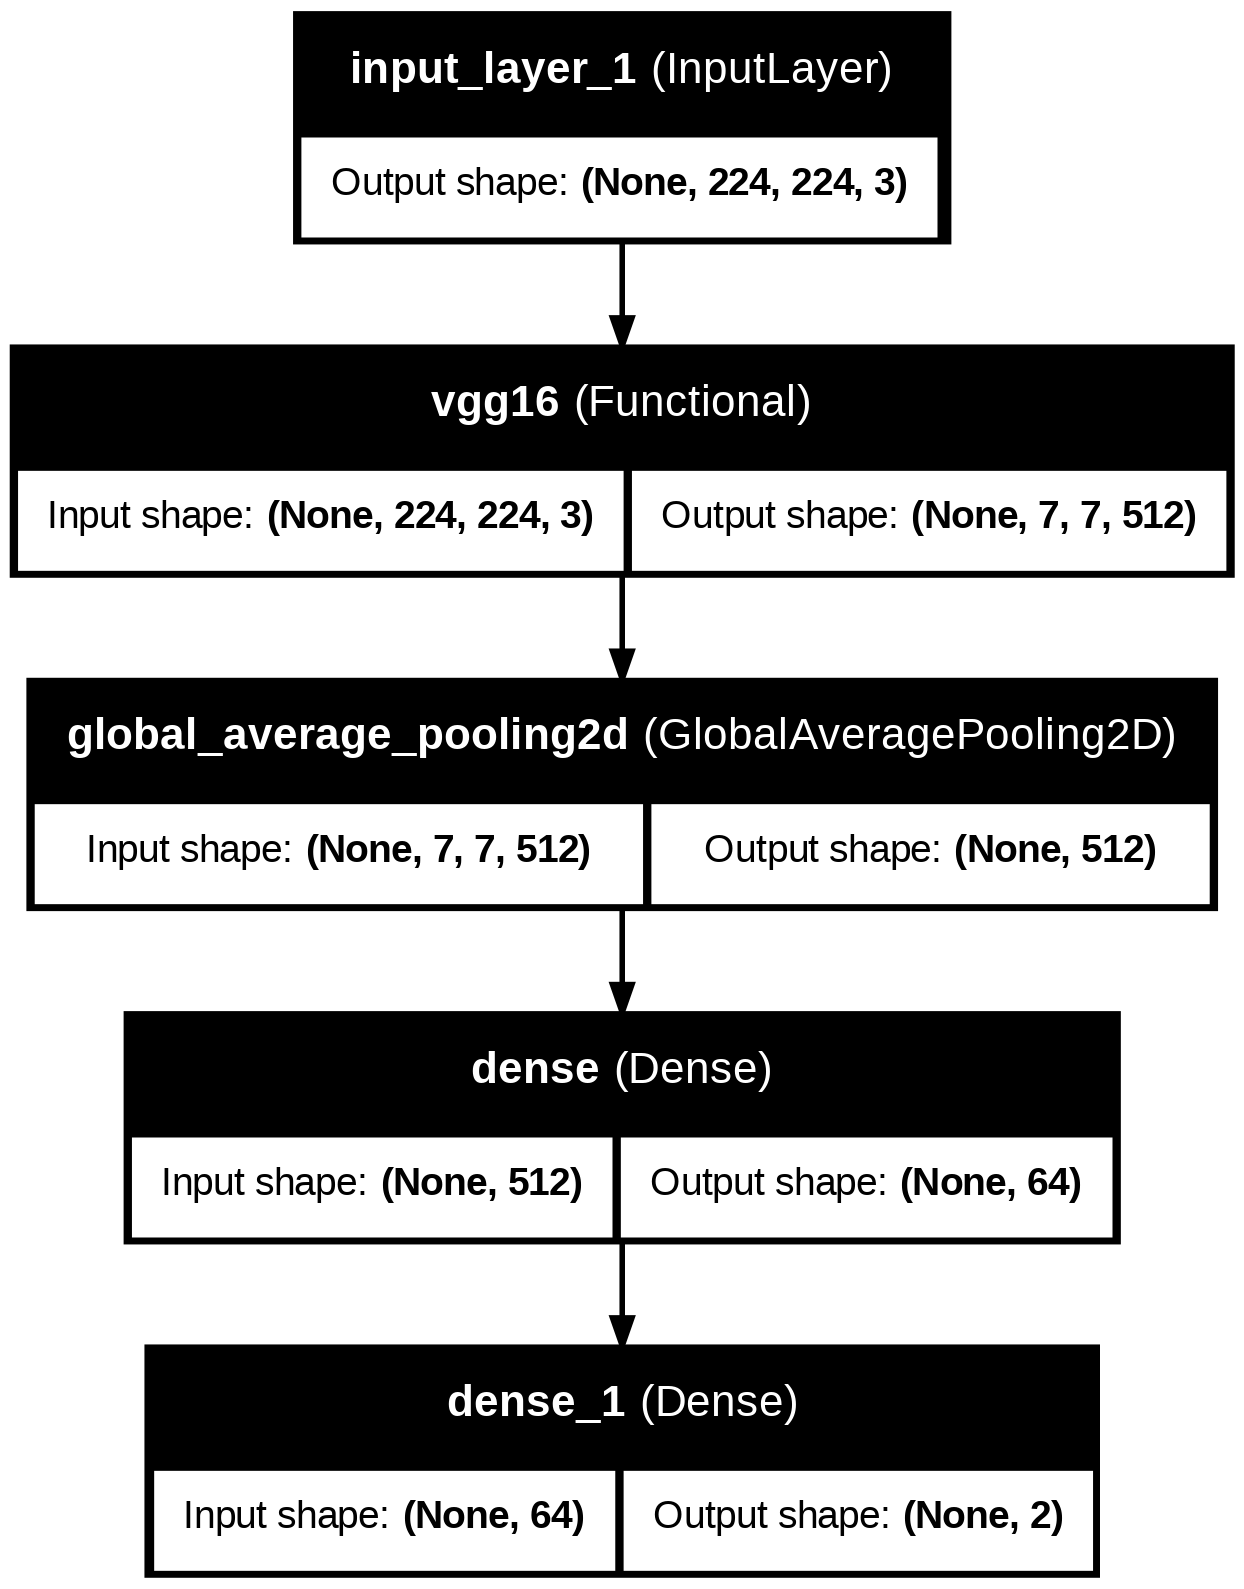

In [4]:
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


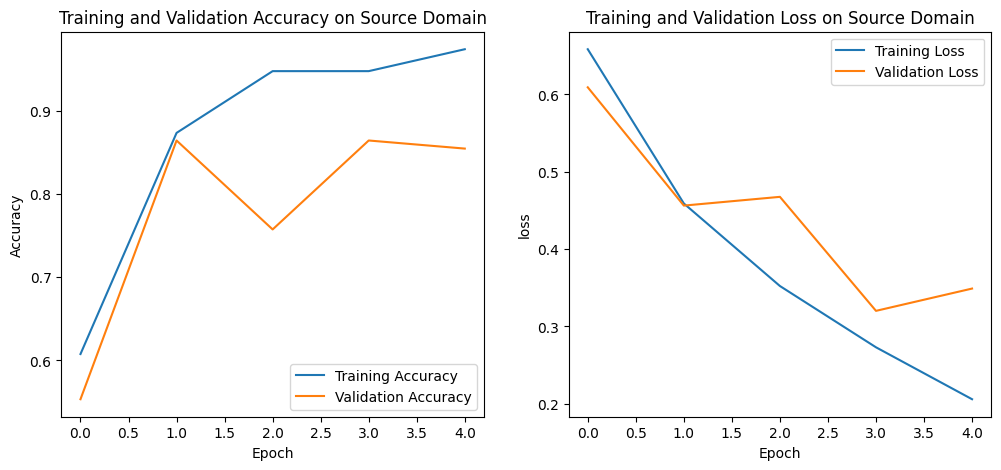

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy on Source Domain')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss on Source Domain')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='best')

In [ ]:
 # Save the weights
#model.save_weights("model_weights.h5")
#model.load("/content/new_model_complete.h5")
#model.save("new_model_complete.h5")
#model.save_weights("new_model_weights.weights.h5")

In [6]:
target_dataset_path = '/content/drive/MyDrive/fruits'
target_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Target data generators
target_train_it = target_datagen.flow_from_directory(
    target_dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)
target_valid_it = target_datagen.flow_from_directory(
    target_dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)


Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [7]:
# Evaluate the model on the target validation set before adaptation
target_loss_before, target_accuracy_before = model.evaluate(target_valid_it)
print(f"Target domain accuracy before adaptation: {target_accuracy_before}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 19s/step - accuracy: 0.4292 - loss: 1.0038
Target domain accuracy before adaptation: 0.4749999940395355


5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 18s/step


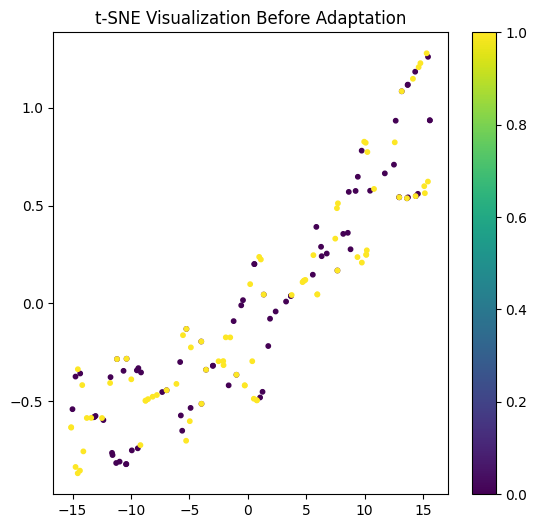

In [8]:
from sklearn.manifold import TSNE
import numpy as np

# Extract features for target dataset before adaptation
features_before = model.predict(target_valid_it)
labels_before = target_valid_it.labels
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_before_tsne = tsne.fit_transform(features_before)
#features_after_tsne = tsne.fit_transform(features_after)

# Plot t-SNE
plt.figure(figsize=(14, 6))

# Before adaptation
plt.subplot(1, 2, 1)
plt.scatter(features_before_tsne[:, 0], features_before_tsne[:, 1], c=labels_before, cmap='viridis', s=10)
plt.title("t-SNE Visualization Before Adaptation")
plt.colorbar()
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [11]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, hp_lambda):
        super(GradientReversalLayer, self).__init__()
        self.hp_lambda = hp_lambda

    def call(self, x):
        return K.reverse_gradient(x, self.hp_lambda)  # Custom gradient reversal


In [12]:
base_model = keras.applications.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False  # Freeze the base layers


In [13]:
# Feature extraction model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
features = keras.layers.GlobalAveragePooling2D()(x)

# Main classifier for ripeness
ripeness_output = Dense(64, activation='relu')(features)
ripeness_output = Dense(2, activation='softmax', name="ripeness_output")(ripeness_output)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras import backend as K

class GradientReversalLayer(Layer):
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, x):
        # Reverse the gradient in the backward pass
        @tf.custom_gradient
        def reverse_gradient(x):
            def grad(dy):
                return -self.hp_lambda * dy
            return x, grad

        return reverse_gradient(x)

    def compute_output_shape(self, input_shape):
        return input_shape

# Example usage in a domain adaptation model
hp_lambda = 0.1
grl = GradientReversalLayer(hp_lambda)(features)

# Domain classifier head
domain_output = Dense(64, activation='relu')(grl)
domain_output = Dense(2, activation='softmax', name="domain_output")(domain_output)

# Now add this `domain_output` head to your model outputs along with the main classification head.


In [15]:
model = Model(inputs=inputs, outputs=[ripeness_output, domain_output])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={"ripeness_output": "sparse_categorical_crossentropy", "domain_output": "sparse_categorical_crossentropy"},
    metrics={"ripeness_output": "accuracy", "domain_output": "accuracy"}
)

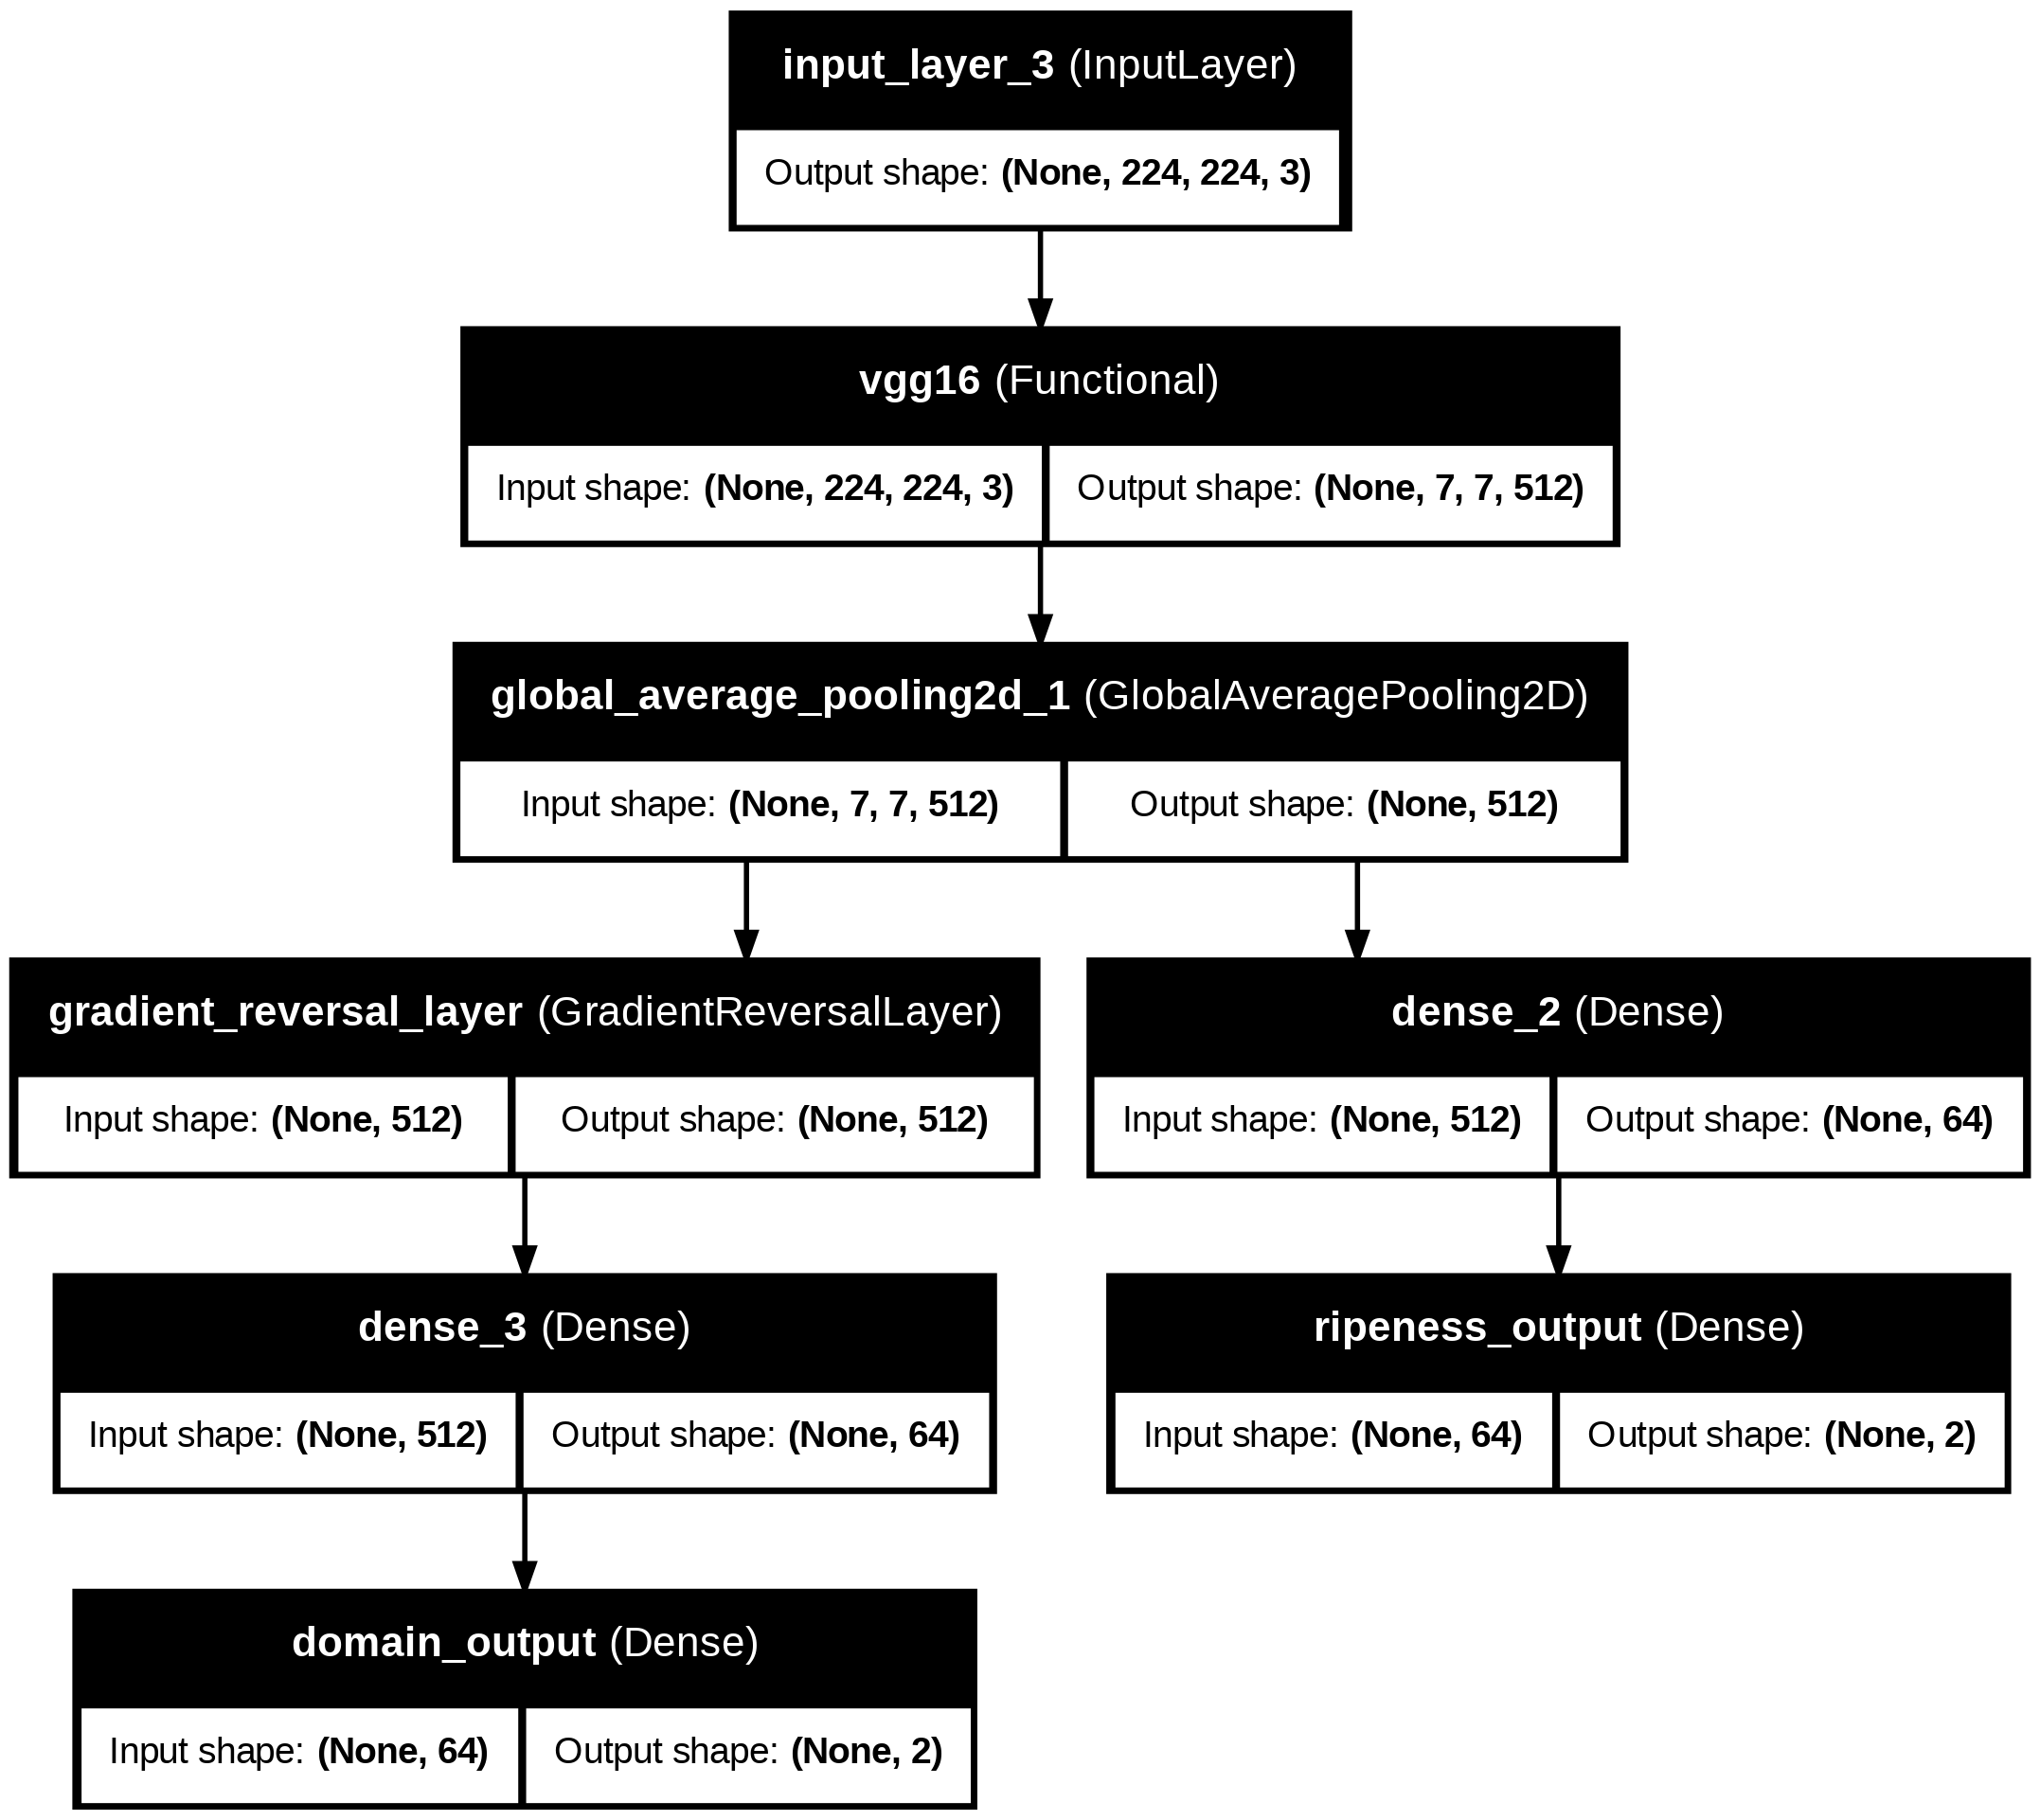

In [23]:
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [18]:
Ssource_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
target_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Source domain generators
source_train_it = source_datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)
source_valid_it = source_datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

Found 418 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [19]:
# Target domain generators
target_train_it = target_datagen.flow_from_directory(
    target_dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)
target_valid_it = target_datagen.flow_from_directory(
    target_dataset_path, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [20]:
# Create domain labels for training (0 for source, 1 for target)
source_labels = source_train_it.labels
target_labels = target_train_it.labels
source_domain_labels = np.zeros_like(source_labels)
target_domain_labels = np.ones_like(target_labels)

# Combine source and target data for domain adaptation
combined_train_x = np.concatenate([source_train_it[0][0], target_train_it[0][0]])
combined_train_y = np.concatenate([source_labels, target_labels])
combined_domain_y = np.concatenate([source_domain_labels, target_domain_labels])

In [21]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model

In [22]:
import numpy as np

# Example of concatenating arrays if using generators
combined_train_y = combined_train_y[:64]
combined_domain_y = combined_domain_y[:64]

print("Combined Train X Shape:", combined_train_x.shape)
print("Combined Train Y Shape:", combined_train_y.shape)
print("Combined Domain Y Shape:", combined_domain_y.shape)


Combined Train X Shape: (64, 224, 224, 3)
Combined Train Y Shape: (64,)
Combined Domain Y Shape: (64,)


In [ ]:
history = model.fit(
    combined_train_x,
    {
        "ripeness_output": combined_train_y,
        "domain_output": combined_domain_y
    },
    validation_data=(
        target_valid_it[0][0],
        {
            "ripeness_output": target_valid_it.labels,
            "domain_output": target_domain_labels
        }
    ),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)
source_loss, source_accuracy = model.evaluate(valid_it)
print(f"target domain accuracy before adaptation: {source_accuracy}")


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 587s 28s/step - accuracy: 0.5838 - loss: 0.6748 - val_accuracy: 0.6438 - val_loss: 0.6690 - learning_rate: 0.0010
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 526s 26s/step - accuracy: 0.6515 - loss: 0.6534 - val_accuracy: 0.5750 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 525s 26s/step - accuracy: 0.6791 - loss: 0.6295 - val_accuracy: 0.6187 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 602s 28s/step - accuracy: 0.7099 - loss: 0.6054 - val_accuracy: 0.6687 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 619s 28s/step - accuracy: 0.7243 - loss: 0.5782 - val_accuracy: 0.6000 - val_loss: 0.6238 - learning_rate: 0.0010
5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 21s/step - accuracy: 0.6098 - loss: 0.6510
Source domain accuracy before adaptation: 0.65625


5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 21s/step - accuracy: 0.6147 - loss: 0.6353
Target domain accuracy after adaptation: 0.6187499761581421


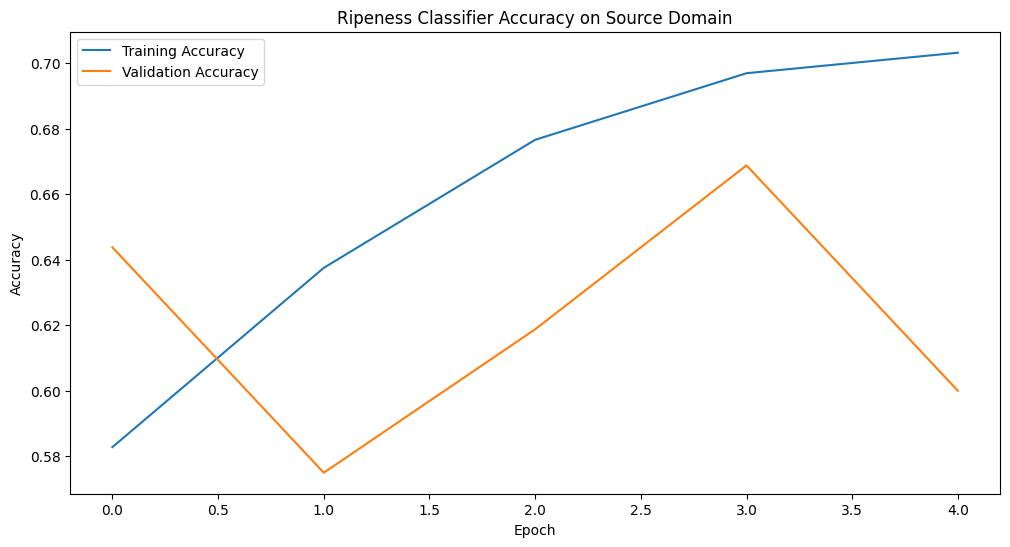

In [ ]:
# Evaluate model on target data after domain adaptation
target_loss_after, target_accuracy_after = model.evaluate(target_valid_it)
print(f"Target domain accuracy after adaptation: {target_accuracy_after}")

# Plot accuracy before and after adaptation
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Ripeness Classifier Accuracy on Source Domain')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


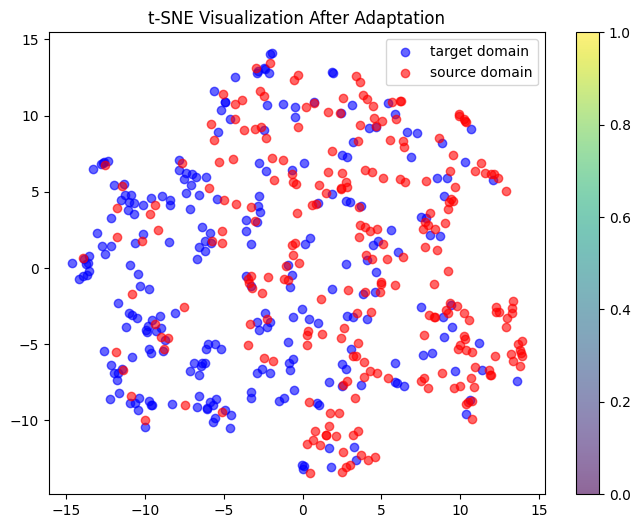

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract features for target dataset before and after adaptation
features_before = model.predict(target_valid_it)
labels_before = target_valid_it.labels


features_after = model.predict(target_valid_it)
labels_after = target_valid_it.labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
features_after_tsne = tsne.fit_transform(features_after)

plt.figure(figsize=(14, 6))

# After adaptation
plt.subplot(1, 2, 2)
plt.scatter(features_after_tsne[labels_after == 0, 0], features_after_tsne[labels_after == 0, 1],
            color='blue', label='Target Domain', alpha=0.6)
plt.scatter(features_after_tsne[labels_after == 1, 0], features_after_tsne[labels_after == 1, 1],
            color='red', label='Source Domain', alpha=0.6)
plt.title("t-SNE Visualization After Adaptation")
plt.legend(loc='best')
plt.colorbar()

plt.show()